In [58]:
# Importing packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Loading data
df = pd.read_csv('initial_data2.csv')

# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Abstract - FINISH

Briefly summarize the objectives, methodologies, key findings, and the selected best-performing
model. Highlight the collaborative learning process among group members

Using a CDC database of weekly-reported vaccine equity data at an United States state level, we sought to predict the percent of people at the country level who have completed the primary series of vaccines and received a booster dose. This data was cleaned and organized for time series prediction. 

# Project and Data Overview

## Project Overview - FINISH

• Clear definition of the problem and its significance.
• Overview of the dataset and its relevance to the problem.

Time series predictions on booster Covid-19 vaccinations
Stakeholders include doctors, government, and vaccine manufacturers
Data from Centers for Disease Control and Prevention (CDC)
Observations are at a state level (multiple observations for each Date)
Reported weekly from 2021-2023 


Our goal for the project was to use time series prediction to predict the percent of people in the United States who have completed the primary series of Covid-19 vaccinations and received the first booster dose. Our dataset was taken from the Centers for Disease Control and Prevention (CDC). The observations occur at the state level, with each state reporting Covid-19 vaccination data daily starting in September 2021. The last date in the dataset is **May 18th, 2023**. 

## Data Overview and Preprocessing

 Brief description of the dataset.
• Overview of common data preprocessing steps for time series prediction, including
challenges.

Once again, the data from the dataset that we used was collected by the Centers for Disease Control and Prevention (CDC). The data is made accessible through the CDC's Application Programming Interface (API). The observations occur at the state level, with each state reporting data every day from **September 2021 until June 2022, then switching to weekly data until May 2023**. Our predictor variable we are using is `Additional_Doses_Vax_Pct` in which we aim to predict the percent of people in the United States who have completed the primary series of Covid-19 vaccinations and received the first booster dose.

Before beginning the time series prediction, I will briefly introduce the data preprocessing steps we took on our dataset.

### Imputing missing values and removing redundant features

The goal for the project was the predict the percentage of the population in the United States that has received the initial booster. To start, we eliminated features with more than 1,000 missing values, as they relate to the bivalent booster or second booster distribution. The second booster was introduced about a year after the initial booster. To avoid data leakage, we ensured that data regarding the second booster doses are absent, given that these vaccines weren't available at the time of predicting our initial booster.

Columns existed for both the proportion of people in a state who had been vaccinated and the actual number who received the vaccine. Since these essentially measured the same metric, albeit at different scales, we felt it redundant. Hence, we discarded the count features and retained the proportion columns, ensuring consistent scaling across states.

Furthermore, a significant portion of data before November 2nd, 2021, was missing. Research revealed that this date aligned with the CDC’s recommendation for children aged five to eleven to receive the vaccine (Kates et al., 2021). This led us to adjust our dataset's starting point to this date for consistency. We observed a significant number of missing entries for December 14th, 2022. While the cause remains unclear, our research into time series imputation techniques led us to select the Last Observation Carried Forward (LOCF) method (Abulkhair, 2023). Consequently, we used the data from December 7th, 2022, to fill the gaps for those states with incomplete data on December 14th, 2022.

In [2]:
#### Data Preparation and Cleaning

# find na value counts
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# columns with over 1000 missing values
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# remove columns with over 1000 missing
df = df.drop(columns=columns_with_over_1000_missing)

# list of numerical columns wihh equivalent percentage columns to drop
columns_to_drop = [
       'Administered_Dose1_Recip',   
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',  
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus', 
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus', 
       'Additional_Doses_50Plus', 
       'Additional_Doses_65Plus']

# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

# Defining response variable for easier 
pred_var = 'Additional_Doses_Vax_Pct' 

given_date = pd.to_datetime('2021-11-02') 

df = df[df['Date'] > given_date]

specific_day = '2022-12-14'  

specific_day_data = df.loc[df['Date'] == specific_day]

rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]


location_values = rows_with_missing_values['Location'].tolist()

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['year'] == 2022) & (df['month'] == 12)]

for location in location_values:
    # Subset data for the specific location
    location_data = df[df['Location'] == location]
    
    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]
    
    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.bfill()
    
    # Update the original DataFrame with the imputed data for the current location
    df.loc[imputed_data.index, imputed_data.columns] = imputed_data

### Temporal Aggregation:

Upon deeper data analysis, we discovered a shift in June 2022, where the API transitioned from daily to weekly reporting. To maintain consistency, we chose to resample our dataset to capture weekly observations every Wednesday, aligning with the reporting pattern post-June 2022.

In [3]:
june_2022_data = df[(df['year'] == 2022) & (df['month'] == 6)]

dec_2021_data = df[(df['year'] == 2021) & (df['month'] == 12)]

df['day_of_week'] = df['Date'].dt.day_name()

# Identifying day of week
given_date = pd.to_datetime('2022-06-22') 
days = df[df['Date'] > given_date]

df = df[df['day_of_week'] == 'Wednesday']

### Feature Engineering:

In our time-series analysis, we recognized the value of feature engineering to uncover potential predictors not explicitly present in the CDC’s API. Consequently, we integrated columns indicating the quarter, month, year, day of the week, day of the month, day of the year, and week of the year the observation was taken. Additionally, we established columns denoting the season of the observation (Winter, Spring, Fall, or Summer). We incorporated a Boolean column to indicate if the week of the observation encompassed a holiday, as per the `holidays` Python library, and another to denote if it contained a vaccine announcement by the CDC (Montel, 2017; Hahn, n.d.).

In [4]:
# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'
    

    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'
    
    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Convert us_holidays to a pandas Series of datetime objects
us_holidays_series = pd.Series(pd.to_datetime(list(us_holidays)))

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays_series) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays_series)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine which weeks have a holiday
holiday_weeks = us_holidays_series.dt.strftime('%U-%Y').unique()

# Assign a "holiday season" for every date that's within a week having a holiday
df['holiday_season'] = df['Date'].dt.strftime('%U-%Y').isin(holiday_weeks)

In [5]:
# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))

# Convert announcement dates to week-year format
announcement_weeks = [date.strftime('%U-%Y') for date in announcement_dates]

# Check if the date in the dataset is within the same week of any announcement dates
def in_announcement_week(date):
    return date.strftime('%U-%Y') in announcement_weeks

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(in_announcement_week)

### Outlier Detection
#### Segmented Analysis Outlier Detection on Aggregated Data

For outlier detection, we used the average for each feature across observations for each date so that we could make the date the index. We decided to use segmented analysis for outlier detection which breaks the dataset into monthly segments and calculates the IQR for each segment. This can help identify if outliers are specific to certain months because the rate of vaccination varies greatly month-to-month. 

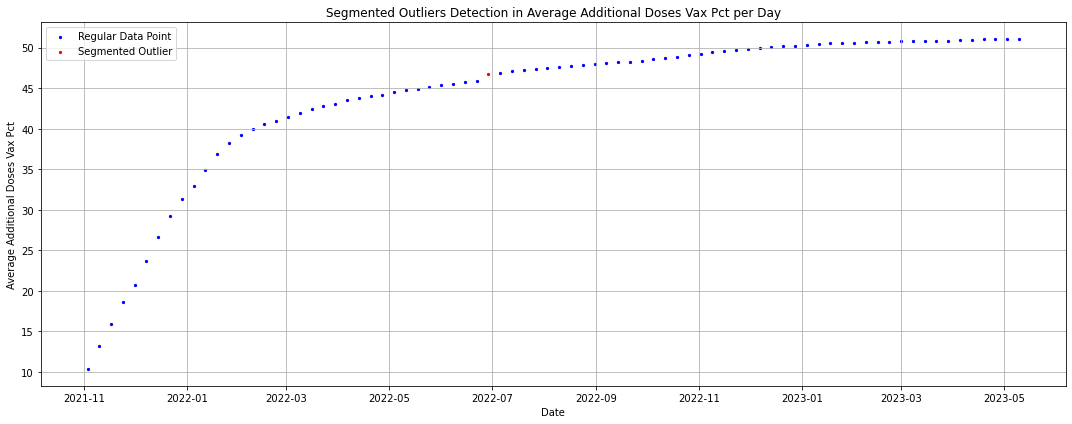

In [6]:
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()
# Convert 'Date' to datetime format
avg_vax_pct_per_day['Date'] = pd.to_datetime(avg_vax_pct_per_day['Date'])

# Create a month-year column for segmentation
avg_vax_pct_per_day['Month_Year'] = avg_vax_pct_per_day['Date'].dt.to_period('M')

# Group by Month_Year and calculate IQR for each month
iqr_values = avg_vax_pct_per_day.groupby('Month_Year')['Additional_Doses_Vax_Pct'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75))).reset_index()
iqr_values.columns = ['Month_Year', 'IQR_Values']
iqr_values['Q1'] = iqr_values['IQR_Values'].apply(lambda x: x[0])
iqr_values['Q3'] = iqr_values['IQR_Values'].apply(lambda x: x[1])
iqr_values['Lower_Bound'] = iqr_values['Q1'] - 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])
iqr_values['Upper_Bound'] = iqr_values['Q3'] + 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])

# Merge the IQR values back to the main dataframe
avg_vax_pct_per_day = pd.merge(avg_vax_pct_per_day, iqr_values, on='Month_Year')

# Determine if a data point is an outlier for its respective month
avg_vax_pct_per_day['is_segmented_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < avg_vax_pct_per_day['Lower_Bound']) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > avg_vax_pct_per_day['Upper_Bound'])
# Scatter plot to see segmented analysis outliers
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'], 
            color='blue', s=5, label='Regular Data Point')

plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'], 
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CHECK/FINISH

As we can see, there is one outlier in our dataset. However, the detected outlier doesn't seem to deter away from the overall trend of the data. There is a slight jump between the detected outlier and the point before it, maybe causing that point to be detected as an outlier. However, given the scale of the data, the point still follows the overall trend of the data and is not drastically different from the points surrounding it. For this reason, we continued on without removing the outlier. 

### Exploratory Data Analysis
#### Temporal Visualizations & Seasonal Decomposition:

In [7]:
# group data by date as there are multiple entires per each date
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()
# set index to date
time_series_data = time_series_data.set_index('Date')

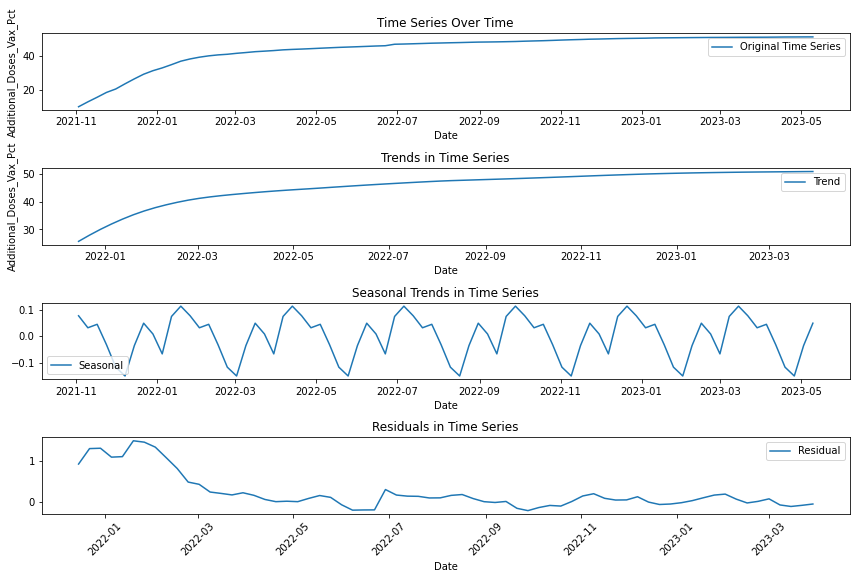

In [8]:
# STL decomposition to investigating trends, seasons and residual

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform STL decomposition with a known seasonality period (e.g., 12 for monthly data)
result = sm.tsa.seasonal_decompose(time_series_data[pred_var], model='stl', period=12)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

# Plot a subset of data (e.g., every 30th data point)
plt.subplot(4, 1, 1)
plt.plot(time_series_data[pred_var], label='Original Time Series')
plt.legend()
plt.title('Time Series Over Time')
plt.xlabel('Date')
plt.ylabel(pred_var)


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trends in Time Series')
plt.xlabel('Date')
plt.ylabel(pred_var)



plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Trends in Time Series')
plt.xlabel('Date')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residuals in Time Series')
plt.xlabel('Date')

# Customize x-axis labels to rotate by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


We have used the STL decomposition to investigate potential trends, seasons and residuals. Based on the STL plot, we have learned that `Additional Doses Vax Pct` has a very steep increase in the first 4-5 months after its initial release and then the rate has tapered and increased at a small and steady rate. This was expected as most people who wanted the booster, receved it when it first came out. The seasonal plot provides clear evidence for a seasonal pattern. This pattern is something we kept in mind and explored further in variable analysis. We will have to account for this pattern in a variety of ways moving forward with the project. For example one of the solutions is to use an ARIMA model which can account for seasonal components. However, for other models we have creaed a categorical `Season` variable. Lastly, the Residual pattern suggests that teh STL may not have adequately captured some underlying patterns or structures in our time series data. 

### Correlation Analysis:

To investigate lag we have plotted an ACF graph. The pattern the ACF plot exhibited is commonly observed in time series data with a strong short-term memory or persistence. It implied that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. To further investigate the lag we have plotted the PACF graph which showed the most significant lag at value of 1. 

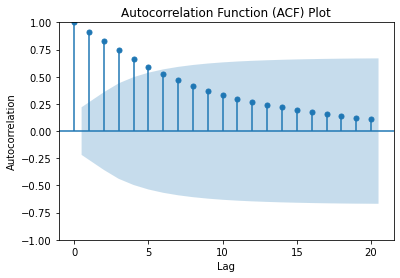

In [18]:
# ACF plot

# Create the ACF plot
plot_acf(time_series_data[pred_var])

# Customize the plot (optional)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

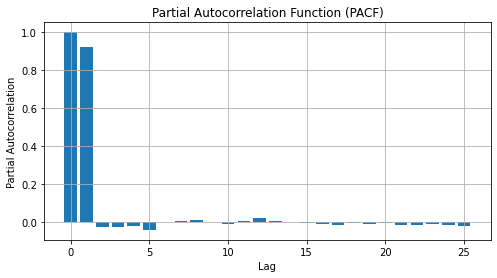

In [21]:
# PACF Plot

# Calculate the PACF
pacf = sm.tsa.pacf(time_series_data, nlags=25)

# Create the PACF plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(pacf)), pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Methodology

## ARIMA Model

### Data Preparation

. Data Preparation:
    • Describe the specific dataset preparation steps for the ARIMA model.
    • Show your dataset is stationary, since stationarity is a key assumption for ARIMA
models to perform effectively.
    • Concisely describe the ARIMA model's key parameters.
    • Explain any transformations or adjustments made to the data for compatibility with
the ARIMA model.

For the data preparation steps for the ARIMA model, I started by grouping the data by date. This was necessary as otherwise the data contains multiple entries for each data for each state, and to predict on the country level, we had to group the data by date. You will see that I grouped by date as well for the rest of the models as well. On top of the grouping, our group decided to also scale the data using MinMaxScaler. We ran the models without scaling and with scaling, and found that scaling the data on a scale from 0 to 1 drastically improved the RMSEs for every model. This is most likely because our predictor variable maxes out at around 50-60%, and we found that putting all variables on the same scale from 0 to 1 reduced to noise of the data quite a bit. Lastly for all my models, I did a train-test split using the first reported date in 2023 as the boundary. The train dataset comprised of all observations in 2021 and 2022. The test dataset comprised of all observations in 2023. This resulted in train being 76.25% and test being 23.75% of the data.

In [29]:
# Read CSV
df = pd.read_csv('df_post_eda.csv')

# Group by date to get vaccinations at the country level
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)

# Scale data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Train-Test split
split_date = '2023-01-03'
train = df_scaled[df_scaled.index < split_date]
test = df_scaled[df_scaled.index >= split_date]

#### Stationarity Analysis

In [17]:
X = df_scaled.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.009253
p-value: 0.001363
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587


To chek if our data is stationary we have performed the ADF test. With the null hypothesis staing that the data is not stationary. Since our $p-value \le 0.05$, we had sufficient evidence to reject the null hypothesis ($H_0$), therefore the data does not have a unit root and is stationary. This finding is helpful as it means we can move forward with an ARIMA model with no further data modifications.

#### Key Parameters

The 3 parameters that define the ARIMA model are `p`, `d`, and `q` that denote the number of lagged (or past) observations to consider for autoregression, the number of times the raw observations are differenced, and the size of the moving average window respectively. ARIMA uses differencing to make the data stationary. Differencing, at its simplest, involves taking the difference of two adjacent data points. (https://www.projectpro.io/article/how-to-build-arima-model-in-python/544) Hence, because our data is stationary, we assumed values for `d` greater than 0. As you can see below, I ran an ADF test on different orders of differencing, and saw for most values of d greater than 0 are below the significant p-value of 0.05. However, looking at the p-value for the 1st order of differencing, the value seems to be slightly above 0.05. It is still very close to the threshold, so to be conservative, I still looked into d values of 1. Looking at the PACF graph we did, we can see that the 1st lag to be the most significant, thus I considered values of `p = 1`. 

In [26]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_scaled)
print('p-value:', result[1])

result = adfuller(df_scaled.diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled.diff().diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled.diff().diff().diff().dropna())
print('p-value:', result[1])

p-value: 0.0013628258781567357
p-value: 0.0052358326581608905
p-value: 3.1813811354700045e-21
p-value: 7.021575729809569e-10


### Model Building

    • Explain the training process for the ARIMA model.
    • Concisely describe the ARIMA model's key parameters tuning and its final parametervalues.
    • Discuss challenges faced during the training phase and their resolutions.

#### Base Model

As previoiusly mentioned, I first noted that I would initially consider values of `p=1` and `d=0`. I first ran a base ARIMA model to see the baseline RMSEs of the model without any parameter tuning.

In [35]:
# Fit an ARIMA model on the training data
order = (1, 0, 0)  # Initial, Lag=1
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.06979395927071978
Test RMSE: 0.022443458428318103


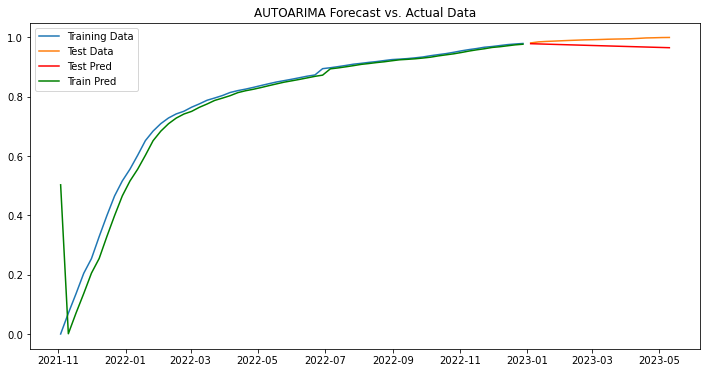

In [34]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

#### Tuning the Hyperparameters

From the base model, the RMSEs that returned were fairly low. The test RMSE was lower than train RMSE, indicating there not being a problem of overfitting. I started with a large grid search in the hyperparameters, considering values for `p`, `d`, `q` from 0 to 5. I initially ran into some problems here because I initially did **walk-forward validation to tune the parameters, however, I wasn't returning desirable results. I realized I had to do cross-validation to make predictions off the train and validation datasets. From there, I was able to achieve much more desirable RMSE results**

In [38]:
# Define the range of hyperparameters for the grid search
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)  
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (4, 4, 4)
Lowest Average Test RMSE: 0.007670700186398619


In [48]:
order = (4, 4, 4)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.01647667294252917
Test RMSE: 0.06328555670886611


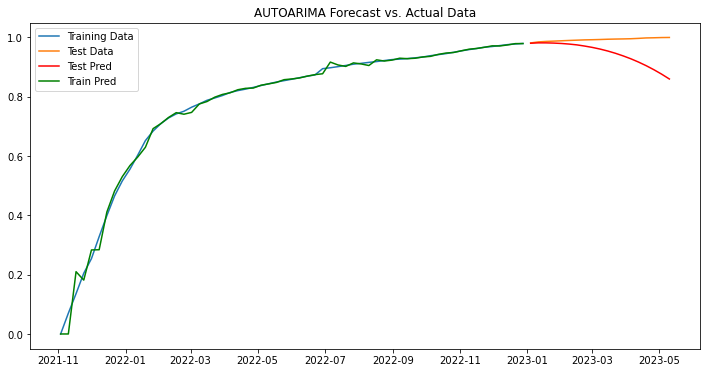

In [49]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

With this grid search, I return `p=4`, `d=4`, `q=4`, which returned low RMSEs. However, the data seems to be overfitting on the training data. While the train RMSE decreased compared to the baseline model, the test RMSE actually increased. I next decided to narrow the grid search and set `p=1` as the PACF graph indicated that a lag of 1 was most significant and see if that would reduced the overfitting.

In [39]:
# Define the range of hyperparameters for the grid search
p_values = [1]
d_values = range(0, 5)
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)  
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (1, 2, 4)
Lowest Average Test RMSE: 0.009003617936057773


In [53]:
order = (1, 2, 4)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.010801980549264008
Test RMSE: 0.00693365638067238


Setting `p=1` seemed to reduce the overfitting issue I faced in the course grid search. Getting parameters `d=2` and and `q=4` seemed to reduce both the train RMSE and test RMSE (test RMSE dropped significantly). Considering our data is stationary and a `d=0` value is sufficient, I wanted to see if searching through only `q` values and setting `p=1` and `d=0` would return lower RMSEs than the `(1,2,4)`. 

In [45]:
# Define the range of hyperparameters for the grid search
p_values = [1]
d_values = [0]
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)  
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (1, 0, 3)
Lowest Average Test RMSE: 0.014231559884163802


In [52]:
order = (1, 0, 3)  
model = ARIMA(train, order = order)
fit_model = model.fit()

train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.06973618675533075
Test RMSE: 0.0737955069903818


### Model Performance

   **Evaluate the ARIMA model using your chosen performance metrics and data
    visualization techniques.**

As we can see from the previous grid search, forcing `d=0` actually returned a similar train RMSE to the base model but a higher test RMSE than the base model, as well as introducing some overfitting. Thus values of `p=1`, `d=2`, and `q=4` return the best RMSEs for the ARIMA model. **INTERPRET THE MODEL** 

**We’ll employ the ARIMA(1,2,4) configuration:**

**1 lags for autoregression (AR)
2nd order differencing (I)
4 moving average terms (MA)**

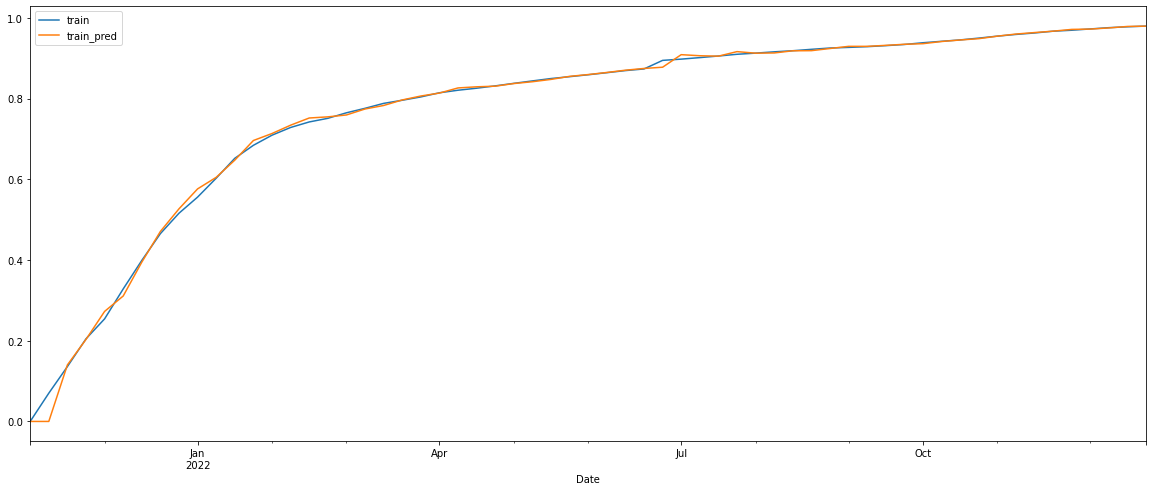

In [55]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

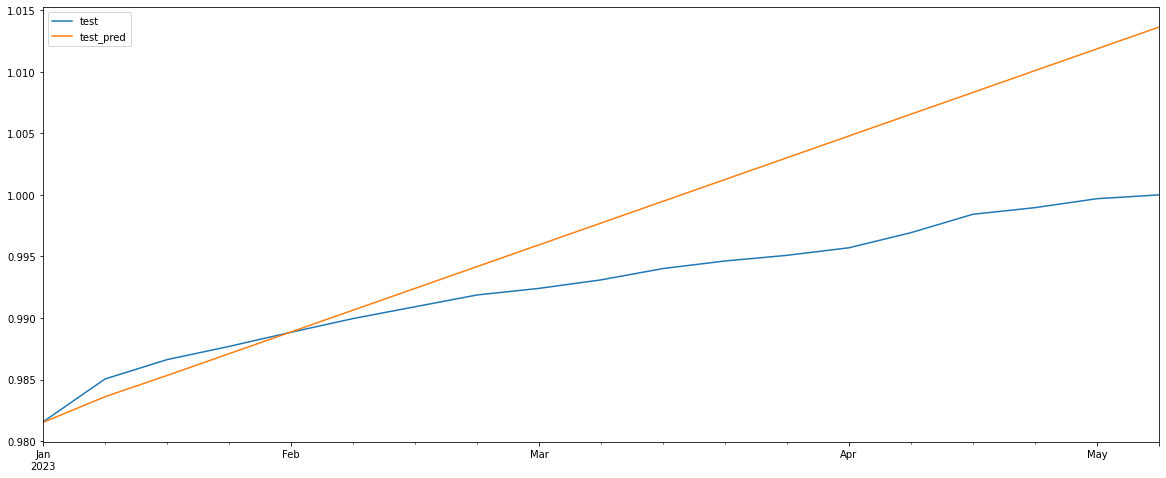

In [56]:
pd.concat([test, test_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

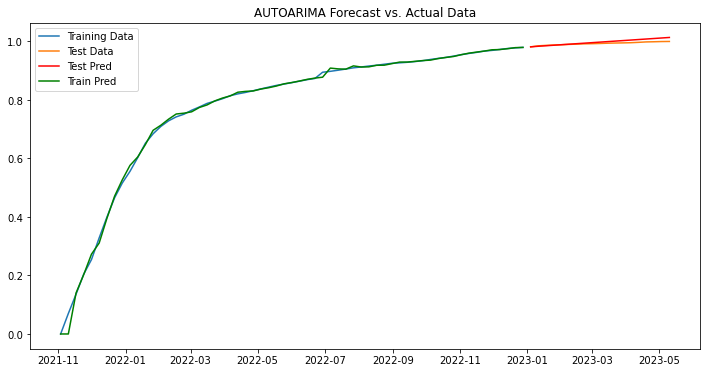

In [57]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## Auto-ARIMA Model

### Data Preparation

   **Concisely describe the Auto-ARIMA model's key parameters and its difference against ARIMA**
    - Describe the specific dataset preparation steps for the Auto_ARIMA model.
    • Explain any transformations or adjustments made to the data for compatibility with Auto-ARIMA

Auto ARIMA itself generates the optimal p, d, and q values which would be suitable for the dataset to provide better predictions without needing to generate the values myself.(https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd) The default values for `p` , `d`, and `q` are (1,1,1,12) for seasonal data (which noted before, our data seems to exhibit seasonality). 


### Model Building

    Explain the training process for the Auto_ARIMA model.
    • Discuss challenges faced during the training phase and their resolutions.
    • Concisely describe the ARIMA model's key parameters tuning and its final parameter values

### Model Performance

    Evaluate the Auto-ARIMA model using your chosen performance metrics and data visualization techniques.
    • Compare it with the best performance of ARIMA model that you built above.
    • Try to explain the difference.

## Prophet (Univariate) Model

### Data Preparation

    • Articulate the advantages and benefits of using Prophet over models from the ARIMA family. Concisely describe the architecture and key parameters of the Prophet (univariate) model,

Much of the data preparation I did for the Prophet models were similar to what I did for the ARIMA models and the rest of the models in this report. I grouped the data by date so we can predict the vaccination rate on the country level and have 1 unique value per date. I also scaled the data the same way as the ARIMA models. A little differently, I decided to remove the seasonality features that we created in the feature enginerring section. This is because Prophet automatically incorporates seasonality patterns. These step was in preparation for the Prophet Multivariate model. For the Prophet Univariate model, the date column must be renamed as `ds` and the predictor variable as `y`, in which I did in this step. I did the same train-test split as the ARIMA models.

In [64]:
# Read csv
df = pd.read_csv('df_post_eda.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

grouped = df.groupby(df.index).mean()

pred_var = 'Additional_Doses_Vax_Pct'

# Dropping Unncessary Columns
columns_to_drop = ['MMWR_week', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'Additional_Doses_Vax_Pct_1_w_lag']
df = grouped.drop(columns=columns_to_drop)

# Scale data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Subsetting to Date and Predictor -> making Prophet (Univariate) dataframe
df_single = df_scaled.groupby(df_scaled.index)[pred_var].mean()
df_single = pd.DataFrame(df_single)
df_single.reset_index(level=0, inplace=True)
df_single = df_single.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})

split_date = '2023-01-03'

train = df_single[df_single['ds'] < split_date]
test = df_single[df_single['ds'] >= split_date]
df_single.head()

,ds,y
0,2021-11-03,0.000000
1,2021-11-10,0.070026
2,2021-11-17,0.135949
3,2021-11-24,0.204748
4,2021-12-01,0.254180


### Model Building

    • Explain the training process for the Prophet (univariate) model.
    • Discuss any additional steps you have taken to optimize performance, if applicable
    • Concisely describe the Prophet (Univariate) model's key parameters tuning and its final parameter values.
    • Discuss challenges faced during the phase and their resolutions. 

Prophet models take into account different trend factors, where you can specify a piecewise linear model (default) or logistic growth model. This was an input into the model that I was unaware of. For much of the initial modelling of my Prophet models, I kept the default linear model. While I achieved comparable RMSEs to the other models, I dealt with much more overfitting than I did when I set `growth='logistic'`. This is because our predictor variable seems to follow more closely a logistic growth than linear growth, resulting in much less overfitting to the training data. Below shows baseline Prophet models I ran with the two different trend factors. As you can see, setting `growth='logistic'` seemed to increase the baseline RMSEs in comparison to the default linear model. However, the baseline Prophet model with `growth='logistic'` appeared to have no overfitting issues. After much trial and error with the two trend factors, I decided to continue setting parameter `growth='logistic'` to avoid overfitting and aimed to reduce the RMSE through parameter tuning.

#### Default Linear Growth Model

In [65]:
# Create a Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.0028713622193601443
Test RMSE: 0.029572437335438392


#### `Growth = 'Logistic'`

In [68]:
train['cap'] = 1
test['cap'] = 1

# Create a Prophet model
model = Prophet(growth='logistic')

# Fit the model on the training data
model.fit(train)
 
# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113726182446
Testing RMSE: 0.24414838647504167


Prophet models allow you to include additional regressor variables to improve the accuracy of the forecasts. For instance, you can add a holiday component and a seasonality compenent to the Prophet model. 

First, I tried adding US holidays to the model. However, doing this actually resulted in no actual change in the baseline train and test RMSE. After some research, I learned that this was because our data has been aggregated to a weekly frequency. Holidays that don't fall on the particluar date in our dataset will be ignored. Because our dataset is only Wednesdays, all of the US Holidays were ignored and the holidays had no impact in the model. We have feature engineered a Holiday boolean column that I dropped for the Univariate Prophet model, but I do include in the Prophet Multivariate model. 

Next, you can specify `seasonality_mode` to `'multiplicative'` or `'additivite'` (default). I attempted to set `seasonality_mode = 'multiplicative'`, however once again, this did not change the baseline RMSEs. This means our seasonality is relatively `additive` and that the seasonal variation in our data is relatively constant over time which can be seen in the seasonal decomposition section above.

#### Holiday Component

In [69]:
# Create a Prophet model
model = Prophet(growth='logistic')
model.add_country_holidays(country_name='US')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:24:22 - cmdstanpy - INFO - Chain [1] start processing
15:24:23 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113990148273
Testing RMSE: 0.2441478284340313


#### Seasonality Component

In [70]:
# Create a Prophet model
model = Prophet(growth='logistic', seasonality_mode='multiplicative')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:25:48 - cmdstanpy - INFO - Chain [1] start processing
15:25:48 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113726182446
Testing RMSE: 0.24414838647504167


#### Tuning Cross Validation

Prophet has a `cross_validation()` function that allows for time series cross validation to measure forecast error using historical data. This is done by specifying a forecast `horizon` within the training dataset, then specifying an `initial` training period, and spacing between cutoff periods (`period`). After some trial and error, I learned that chaning the specifications of these 3 parameters actually returned different best parameters. Thus I tuned, the `horizion`, `initial`, and `period` parameters to determine which to use on my training data that would return the best RMSEs. The code for that grid search is below (I didn't run in this file for the sake of runtime). The best parameters for the cross validation function were `{'horizon': 7, 'initial': 49, 'period': 7}`.

In [ ]:
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial': list(range(49, 210, 7)),  
    'period': [7, 14] ,  
    'horizon': [7, 14] 
}

all_params = list(ParameterGrid(param_grid))

best_rmse = float('inf')
best_params = None

for params in all_params:
    model = Prophet(growth='logistic').fit(train)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'
    
    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

#### Tuning Model Hyperparameters 

Lastly, I tuned 4 hyperparameters: `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`, and `seasonality_mode` (which I already determined should return `additive`). The grid search I did is below (I didn't run again in this file because of the runtime), and the best parameters were `{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}`

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, parallel="processes", initial='49 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

### Model Performance

Using the parameters listed above from my grid search I ran my final Prophet Univariate model. The final train and test RMSE are below. As you can see, the train and test RMSE have decreased significantly from the baseline Prophet model. Also additionally, I was able to reduce the overfitting problem by setting `growth='logistic'` in which the test RMSE is smaller than the train RMSE. 

The final parameter of `changepoint_prior_scale` returned `0.5`, which was the highest provided in the list. The higher value memans the model is made to be moderately flexible in capturing changes in the trend. In addition, `seasonality_prior_scale` and `holidays_prior_scale` returned values of 0.01, the lowest provided in the search list. This means the model forced strong regularization to both seasonality and holiday effects in the data. 

Overall the Prophet Univariate model returned farily good RMSEs in comparison to the other models. Specifically for this model, the test predictions followed the trend of the actual test data the most closely.

In [71]:
# Tuned model
tuned_model = Prophet(growth='logistic', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01, 
                     holidays_prior_scale = 0.01, seasonality_mode = 'additive')

# Fit the model on the training data
tuned_model.fit(train)

# Make predictions on the training set
train_predictions = tuned_model.predict(train)

# Make predictions on the test set
test_predictions = tuned_model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

15:41:46 - cmdstanpy - INFO - Chain [1] start processing
15:41:46 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.01073493701326449
Testing RMSE: 0.009585945963442762


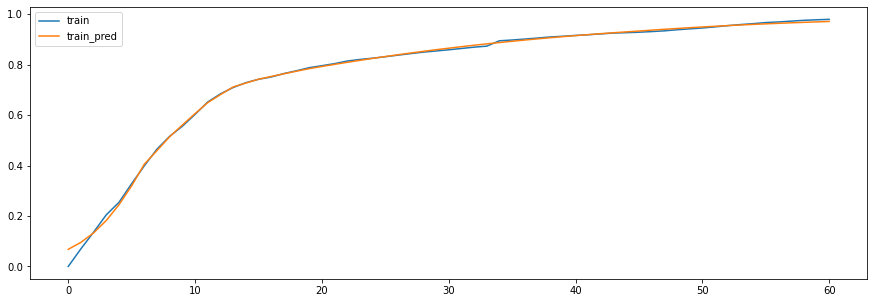

In [72]:
# Plot the training predictions
pd.concat([train['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

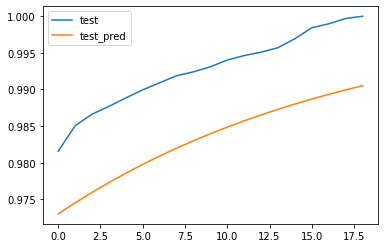

In [73]:
pd.concat([test.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

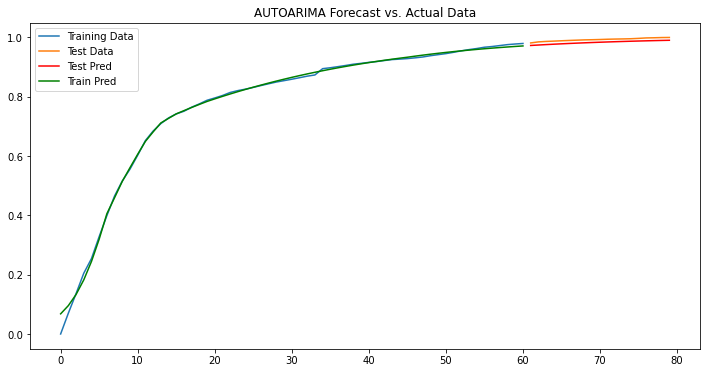

In [80]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(test.index, test_predictions['yhat'], label='Test Pred', color='red')
plt.plot(train.index, train_predictions['yhat'], label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

## Prophet (Multivariate) Model

### Data Preparation
    • Describe the specific dataset preparation steps for the Prophet (multivariate) model,such as the choice of significant predictors.
    • Explain any transformations or adjustments made to the data for compatibility withthe Prophet (multivariate) model.

# Conclusion & Next Steps


Overall the EDA and data processing we have performed so far allowed us to gain a lot of inisght into our data.
Our next goal is to start developing different prediction models. For time series forcasting model we will use the grouped by `Date` data. One of the first models we will develop is ARIMA, which we know is suitable for our stationary data and through tuning it will account for any trend patterns in the prediction variable over time. There is also possibility of using the ARIMAX model which takes into accoutn other selected features.  We will also start working on other prediction models such as Random Forest and Boosting Models (XGBoost etc.) For these models that we will be using the ungrouped data and will have to perform further investigation into the correlation between prediction variable and other features.

# References

Abulkhair, A. (2023, June 13). Data Imputation Demystified | Time Series Data | by Ahmed Abulkhair. Medium. Retrieved October 25, 2023, from https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

Hahn, S. (n.d.). COVID-19 Vaccines. FDA. Retrieved October 25, 2023, from https://www.fda.gov/emergency-preparedness-and-response/coronavirus-disease-2019-covid-19/covid-19-vaccines

Kates, J., Tolbert, J., & Rouw, A. (2021, December 8). An Update on Vaccine Roll-Out for 5-11 Year-olds in the U.S. KFF. Retrieved October 25, 2023, from https://www.kff.org/coronavirus-covid-19/issue-brief/an-update-on-vaccine-roll-out-for-5-11-year-olds-in-the-u-s/

Montel, M. (2017). holidays · PyPI. PyPI. Retrieved October 25, 2023, from https://pypi.org/project/holidays/


https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd